In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib as mpl
import numpy.ma as ma
from scipy import interpolate
import matplotlib.gridspec as gridspec

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions
import quicklook

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/envs/gsw/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def get_varbs(dirname, fname, meshmaskname, time_s):
    
    filesU = general_functions.get_files(dirname, fname, 'grid_U') 
    filesV = general_functions.get_files(dirname, fname, 'grid_V')
    filesW = general_functions.get_files(dirname, fname, 'grid_W')
    filesT = general_functions.get_files(dirname, fname, 'grid_T')
    print('files', fname)
    
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW, scDataset(filesT) as dsT:
        vozocrtx0 = dsU.variables['vozocrtx'][time_s,:,y,x]
        vomecrty0 = dsV.variables['vomecrty'][time_s,:,y,x]
        vovecrtz0 = dsW.variables['vovecrtz'][time_s,:,y,x]
        vosaline0 = dsT.variables['vosaline'][time_s, :, y, x]
        sozotaux = dsU.variables['sozotaux'][time_s,0,0]
        deptht = dsT.variables['deptht'][:]

    with nc.Dataset(os.path.join(dirname, meshmaskname), 'r') as dsM:
        umask = dsM.variables['umask'][0,:,y,x]
        vmask = dsM.variables['vmask'][0,:,y,x]
        tmask = dsM.variables['tmask'][0,:,y,x]
        e1t0 = np.nanmean(dsM.variables['e1t'][0, y, x], axis=0)
        e2t0 = np.nanmean(dsM.variables['e2t'][0, y, x], axis=1)
        e1t = np.cumsum(e1t0) / 1000 # km
        e2t = np.cumsum(e2t0) / 1000 # km

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    vosaline = np.ma.array(vosaline0, mask=1 - tmask)
    
    return vozocrtx, vomecrty, vovecrtz, vosaline, e1t, e2t

In [3]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def get_varb_surf(vosaline_array, salt, varb):
    
    if len(vosaline_array.shape)==1:
        f = interpolate.interp1d(vosaline_array, varb)
        ynew = f(salt)
        varb_array = ynew
        
    elif len(vosaline_array.shape)!=1:
        varb_array = np.full([vosaline_array.shape[-2], vosaline_array.shape[-1]], np.nan)
        for i in range(vosaline_array.shape[-1]):
            for j in range(vosaline_array.shape[-2]):
                vosaline_column = vosaline_array[:, j, i]
                if len(varb.shape)==1:
                    varb_column = varb
                elif len(varb.shape)==3:
                    varb_column = varb[:, j, i]

                try:
                    f = interpolate.interp1d(vosaline_column, varb_column)
                    ynew = f(salt)
                    varb_array[j, i] = ynew
                except ValueError:
                    varb_array[j, i] = np.nan  
                
    return varb_array

In [12]:
def plot_map(kind, ax, vovecrtzp, vovecrtzc, e1tp, e2tp, e1tc, e2tc):
    
    if kind == 'ideal':
        inds = [90, 10]
    elif kind == 'real':
        inds = [130, 10]
        
    if kind == 'ideal':
        mid = 306
    elif kind == 'real':
        mid = 400
    
    min_x, max_x, min_y, max_y = mid-150, mid+150, 20, 210
#     ax.set_xlim([min_x, max_x])
#     ax.set_ylim([min_y, max_y])
    
    vmin, vmax=-1, 1
    cmap = cmo.cm.balance
    cmap.set_bad('silver')

    w_meanp = np.mean(vovecrtzp, axis=0) *1000
    w_meanc = np.mean(vovecrtzc, axis=0) *1000
    
    x_left, y_bottom = e1tp[inds[0]], e2tp[inds[1]]
    x_shift, y_shift = x_left+e1tc, y_bottom+e2tc
    
    ax.pcolormesh(e1tp, e2tp, w_meanp, cmap=cmap, vmin=vmin, vmax=vmax)
    p = ax.pcolormesh(x_shift, y_shift, w_meanc, cmap=cmap, vmin=vmin, vmax=vmax)
    
    print(w_meanc.min(), w_meanc.max())
    
    return ax, p

In [10]:
def load_vel(kind, time_s):
    
    case='base'
    dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'
    
    fname = '1_MCKNZ*'
    meshmaskname = '1_mesh_mask.nc'
    vozocrtxc, vomecrtyc, vovecrtzc, vosalinec, e1tc, e2tc = get_varbs(dirname, fname, meshmaskname, time_s)
    
    fname = 'MCKNZ*'
    meshmaskname = 'mesh_mask.nc'
    vozocrtxp, vomecrtyp, vovecrtzp, vosalinep, e1tp, e2tp = get_varbs(dirname, fname, meshmaskname, time_s)
    
    x_slicec, y_slicec, u_nstgc, v_nstgc, speedsc = quicklook.get_speeds(vozocrtxc, vomecrtyc, 1)
    x_slicep, y_slicep, u_nstgp, v_nstgp, speedsp = quicklook.get_speeds(vozocrtxp, vomecrtyp, 1)
    
    return vozocrtxc, vomecrtyc, vovecrtzc, vosalinec, e1tc, e2tc, vozocrtxp, vomecrtyp, vovecrtzp, vosalinep, e1tp, e2tp

test 0
files 1_MCKNZ*
files MCKNZ*
-3.8837801132883345 2.05892293403546
test 1
files 1_MCKNZ*
files MCKNZ*
-2.214621752500534 4.545017012528011


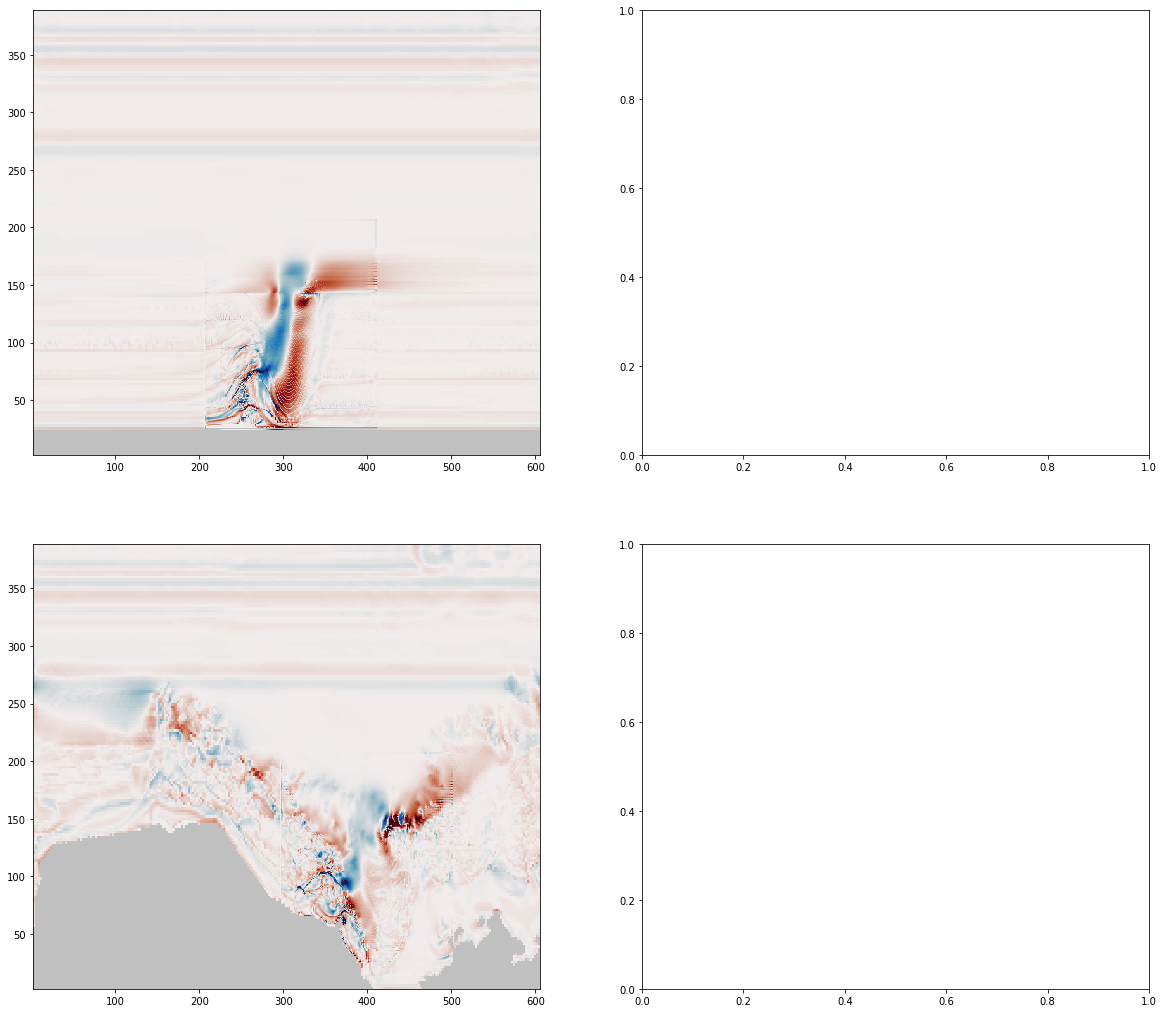

In [13]:
time_s=30

fig, axes = plt.subplots(2, 2, figsize=(20, 18))

for kind, row in zip(['ideal', 'real'], np.arange(2)):
    print('test', row)
    vozocrtxc, vomecrtyc, vovecrtzc, vosalinec, e1tc, e2tc, vozocrtxp, vomecrtyp, vovecrtzp, vosalinep, e1tp, e2tp = load_vel(kind, time_s)
    
    ax = axes[row, 0]
    ax, p = plot_map(kind, ax, vovecrtzp, vovecrtzc, e1tp, e2tp, e1tc, e2tc)